In [1]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import os
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import Data
parse_dates = ['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'shipping_limit_date',
'review_creation_date',
 'review_answer_timestamp',]

OL_Data = pd.read_csv("./OL_Data.csv", 
                      parse_dates=parse_dates,
                      date_parser = pd.to_datetime)



OL_Data_Simp = OL_Data[['order_id','customer_unique_id','product_id','product_category_name_english','seller_id']]
OL_Data_Simp = OL_Data_Simp.drop_duplicates()

<div class="span5 alert alert-info">
<h3>Define Useful Functions</h3>
</div>

In [3]:
#NormalizeSalesToPercentages
#  Take a data frame with columns to normalize (seller sales, customer purchases)
#  and normalize each column, so it adds to 100%.  This sum may be slightly off depending on
#  minPercent, which rounds down to the percentage specified

#  dataFrame - DataFrame with Columns to normalize
#  indexCol - Column in data frame that will not be normalized, but included in returned DataFrame as an id
#  cols to Exclude - Other columns in data frame, that will not be normalized or included in returned Dataframe
#  printUpdate (optional) - Print percentage of completion, useful for large DataFrames
#  decimal (optional) - normalize entries to decimals, as opposed to percentages

def NormalizeSalesToPercentages(dataFrame, indexCol, colsToExclude, minPercent, printUpdate = False,decimal = False):
    i = 0
    copyMat = dataFrame.copy()
    
    for x in copyMat.columns:
        i = i+1
        if(x == indexCol):
            continue
        if(x in colsToExclude):
            copyMat = copyMat.drop(x)
            continue
        
        if(len(copyMat.columns) >100 and i % (len(copyMat.columns)//100) == 0 and printUpdate):
            print(i/len(copyMat.columns)*100)

        col = copyMat[x]
        col = col/sum(col)*100/minPercent
        col = col.apply(math.floor)
        col = col * minPercent
        
        if(decimal):
            col = col/100

        copyMat.loc[:,x] = col
        
    return copyMat

In [4]:
from os.path import exists
#EuclideanDistanceMatrix
#  Take a data frame with columns representing some numerical dimension and an index (unique identifier) column.
#  Find the Euclidean distance of each row to every other row, and print out to specified file, optionally returning
#  the created DataFrame.  This is useful for large matrices, as printing out will not consume working memory as much as storing 
#  all the calculated values during the calculation

#  dataFrame - DataFrame columns representing some numerical dimension and an index
#  indexName - Name of column that is not a dimension, but a unique identifier
#  fileName - Name of File to write out calculations to 
#  loadDataFrame (optional) - return EuclideanDistance DF, read in from file generated
#  printUpdate (optional) - Print percentage of completion, useful for large DataFrames

def EuclideanDistanceMatrix(dataFrame,  indexName, fileName, loadDataFrame=True, printUpdate= False):
    if(exists(fileName)):
        os.remove(fileName)
    
    sub = dataFrame.loc[:, dataFrame.columns!=indexName]
    values = sub.to_numpy()
    
    
    with open("./"+fileName, 'w') as f:
        indexValues = np.transpose(dataFrame[[indexName]].to_numpy())[0]
        
        converted_index = [str(element) for element in indexValues]
        header = "{0},".format(indexName) + ",".join(converted_index) +"\n"
        f.write(header)
        for x in range(len(indexValues)):
            
            if(len(indexValues)>100 and x%(len(indexValues)//100) ==0 and printUpdate):
                print("{0}% ".format(x/len(indexValues)*100))

            index = indexValues[x]
            row = values[x]
            row.shape = (1,len(values[x]))
            
            
            result = np.apply_along_axis(np.linalg.norm, 1, abs(values-row)).T
            
            converted_list = [str(element) for element in result]
            
            text = "{0},".format(index) + \
                              ",".join(converted_list) + \
                              "\n"
            f.write(text)
            
        f.close()
    if(loadDataFrame):
        df =  pd.read_csv("./"+fileName)
        cols = list(df.columns)
        cols.remove(indexName)
        for col in cols:
            df[col] = df[col].astype(float)
        return df

In [5]:
import copy


#ModifiedEuclideanDistanceMatrix
#  Take a data frame with columns representing some numerical dimension and an index (unique identifier) column.
#  Find the Modified Euclidean distance of each row to every other row, defined as follows.  Take row 1, and find indexes 
#  of non-zero Entries.  If row 2 has a 0 valued entry at an index where row 1 has a non-zero entry, set row 2's value at 
#  this index to the negative row 1's value at this index.  Do the same for row 2 compared to row 1, replaceing row 1's 0
#  valued entires where row 2 has a value.  Then compute regular uclidean distance between row 1 and row 2.
#
#  This metric penalizes mosly empty rows more than the standard Eucliden Distance Measurement

#  dataFrame - DataFrame columns representing some numerical dimension and an index
#  indexName - Name of column that is not a dimension, but a unique identifier
def ModifiedEuclideanDistanceMatrix(dataFrame,  indexName):
    sub = dataFrame.loc[:, dataFrame.columns!=indexName]
    values = sub.to_numpy()
    
    indexValues = np.transpose(dataFrame[[indexName]].to_numpy())[0]
    
    #Initialize all zero matrix
    output = np.zeros((len(indexValues),len(indexValues)))
    
    #Reduce computation time by only visiting values below the diagonal
    for y in range(len(indexValues)):
        for x in range(y):
            if x==y:
                #Always a distance of zero between a row and itself
                continue;
                
            row1 = values[y]
            row2 = values[x]
            
            modRow1 = (row1-row2)*(row1==0)+row1
            modRow2 = (row2-row1)*(row2==0)+row2
            
            dist = np.linalg.norm(abs(modRow1-modRow2))
            output[x][y] = dist
            output[y][x] = dist
            
    #Convert to DataFrame, naming coulmns to index Values
    df = pd.DataFrame(output, columns = indexValues)
    #Add index Col to DataFrame at start
    df.insert(0, indexName, indexValues)
    
    return df


#ModifiedEuclideanDistanceSimularityMatrix
#  Take a data frame with columns representing some numerical dimension and an index (unique identifier) column.
#  Find the Modified Euclidean Simularity between every row and every other row in the data frame, defined as follows.
#  
#  - For each row, subtact its non-zero columns from the zeros in those columns of other rows.  
#  - Find the Euclidean Distance between the converted matrix and the row of interest, producing a Row of Distances.  
#  - Divide this Distancerow by the max value in the row, creating a row of values from 1 (max dist) to 0 (min dist)
#  - Subtract the resulting row from 1, producing a simularity row of values from 0 (min simularity) to 1 (max simularity)
#  
#  - Complete the process for every row, then average the entry in row A col B with that of row B col A, and store the
#    result in both positions
#
#  dataFrame - DataFrame columns representing some numerical dimension and an index
#  indexName - Name of column that is not a dimension, but a unique identifier
def ModifiedEuclideanDistanceSimularityMatrix(dataFrame,  indexName):
    
    sub = dataFrame.loc[:, dataFrame.columns!=indexName]
    values = sub.to_numpy()
    
    indexValues = np.transpose(dataFrame[[indexName]].to_numpy())[0]
    output = []
    for x in range(len(indexValues)):
        row = values[x]
        modValues = (values-row)*(values==0)+values

        newRow = np.apply_along_axis(np.linalg.norm, 1, abs(modValues-row)).T
        newRow = 1-newRow/max(newRow)
        output.append(newRow.copy())

    ret = copy.deepcopy(output)
    for ir, row in enumerate(output):
        for ic, col in enumerate(row):
            ret[ir][ic] = (output[ir][ic]+output[ic][ir])/2
    
    df = pd.DataFrame(ret, columns = indexValues)
    df.insert(0, indexName, indexValues)
    
    return df

In [6]:
#GenerateAndWriteOutSimularityScoreMatrices
#  Take a data frame with columns representing a normalized measurement (should add to 100) and an index (unique identifier) column.
#  After separating values from index, remove duplicate columns (similar percentage spread grouped together) and return:
#    - A DataFrame with Percentage Spreads for each group and count of members in this group
#    - Euclidean Distance matrix (nxn), distance between groups
#    - Cosine Similarity matrix (nxn), simularity between groups
#    - Modified Euclidean Distance matrix (nxn), distance between groups
#    - Modified Euclidean Simularity matrix (nxn), simularity between groups
#
#  NormPercDF - DataFrame with index col and columns normalized to percentages so sum of each column is 100
#  indexName - Name of column that is a unique identifier for its row
#  groupByCategories - the order to sort the percentages in, usually the values of the index column
#  FileNameHeader - this function outputs several files, this string will be used at the start of each file name
#  GroupName - Columns will be grouped if repeated, and renamed to numbers, this is the name of those Groups
#  printUpdate (optional) - print updates, useful for large dataframes
def GenerateAndWriteOutSimularityScoreMatrices(NormPercDF, indexName, groupByCategories, FileNameHeader, GroupName, printUpdate = False):
    #Count Duplicate Entries, for storing Later
    GroupedDF = NormPercDF.set_index(indexName)
    grouped = GroupedDF.T.groupby(GroupedDF.T.columns.tolist(),as_index=False).size()
    grouped = grouped.sort_values(by=groupByCategories, ascending=False)
    
    #Shape before removing duplicate entries
    IndexCol = NormPercDF[indexName]
    NormPercDF =NormPercDF.drop(columns=indexName)
    print("Initial Shape")
    print(NormPercDF.shape)
    
    #Remove Duplicate Entries
    NoDups = NormPercDF.T.drop_duplicates().T    
    NormPercDF.insert(0, indexName, IndexCol)    
    
    #rename Columns
    NoDups.columns = range(len(NoDups.columns))
    NoDups.insert(0, indexName, IndexCol)
    print("Shape After Droping Duplicates")
    print(NoDups.shape)
    
    #Get Euclidean Dist Matrix
    EucDistFileName = "./"+FileNameHeader+"EuclideanDist.csv"
    print('Writing '+EucDistFileName+'...')
    CleanedUp = NoDups.set_index(indexName).T.reset_index()
    temp = CleanedUp.rename(columns={'index': GroupName})
    Dist = EuclideanDistanceMatrix(temp, GroupName, EucDistFileName, True, printUpdate)
        
    #Get the Modified Euclidean Dist Matrix
    ModDist = ModifiedEuclideanDistanceMatrix(CleanedUp, 'index')
    ModDist = ModDist.rename(columns={'index': GroupName})
    ModEucDistFile = "./"+FileNameHeader+"ModifiedEuclideanDist.csv"
    if(exists(ModEucDistFile)):
        os.remove(ModEucDistFile)
    print('Writing '+ModEucDistFile+'...')
    ModDist.to_csv(ModEucDistFile, index=False)    
    
    
    #Modified Eclidean Dist, penalizes empty extries when comparing rows to one another
    ModSim = ModifiedEuclideanDistanceSimularityMatrix(CleanedUp,'index')
    ModSim = ModSim.rename(columns={'index': GroupName})
    ModEucSimFile = "./"+FileNameHeader+"ModifiedEuclideanSimularity.csv"
    if(exists(ModEucSimFile)):
        os.remove(ModEucSimFile)
    print('Writing '+ModEucSimFile+'...')
    ModSim.to_csv(ModEucSimFile, index=False)
    
    #Add Size
    NoDupsIndexed = NoDups.set_index(indexName)
    NoDupsTrans = NoDupsIndexed.T
    temp = NoDupsTrans.reset_index().rename(columns={'index': GroupName})
    NoDupsTransSorted = temp.sort_values(by=groupByCategories, ascending= False)
    NoDupsTransSorted = NoDupsTransSorted.merge(grouped, how='left',on=groupByCategories)
    
    GroupsFileName = "./"+FileNameHeader+"UniqueGroups.csv"
    if(exists(GroupsFileName)):
        os.remove(GroupsFileName)  
    
    print('Writing '+GroupsFileName+'...')
    NoDupsTransSorted.to_csv(GroupsFileName, index =False)
    
    
    #Cosine Simularity Matrix
    Cos = cosine_similarity(NoDupsTrans)
    CosDF = pd.DataFrame(Cos, columns = NoDupsIndexed.columns)
    CosDF = CosDF.reset_index().rename(columns={'index': GroupName})
    
    CosFileName = "./"+FileNameHeader+"CosineSimularity.csv"
    if(exists(CosFileName)):
        os.remove(CosFileName)    
    print('Writing '+CosFileName+'...')
    CosDF.to_csv(CosFileName, index=False)
    
    
    return (NoDupsTransSorted, Dist, CosDF, ModDist, ModSim)

In [7]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from IPython.display import clear_output
import copy


#PrintClusterScores_Euc_ModEuc_Cos
#  Use Agglomerative Clustering to test different distance/simularity metrics
#  Test different cluster counts and linkages for each method, printing 
#  graph of average sillouette score for each, and returning summary of max scores
#
#  sampleXfeatureDF - DataFrame of normalized samples, with features as columns.  Rows should add up to 100
#  ModEucMatrix_nxn - Custom Distacne Matrix between groups
def PrintClusterScores_Euc_ModEuc_Cos(sampleXfeatureDF, ModEucMatrix_nxn):
    
    Scores = {}

    xs = range(2,100)
    linkages = ['complete', 'average']
    metrics = ['Euclidean','Modified Euclidean', 'Cosine']

    subplotCols = 3
    subplotRows = len(linkages)
    plotNum = 1

    for linkage in linkages:
        Scores[linkage] = {}

        sScoresEuc = []
        sScoresModEuc=[]
        sScoresCosSim = []
        print(linkage)
        for x in xs:
            #Print update
            clear_output(wait=True)
            for l in range(linkages.index(linkage)):
                print('Linkage: {0}, finished.'.format(linkages[l]))
            print("Linkage: {0}, x={1} of {2}".format(linkage, x, max(xs)))
            
            #Euclidean Distance Model
            model = AgglomerativeClustering(n_clusters=x,linkage=linkage).fit(sampleXfeatureDF)
            sScoresEuc.append(silhouette_score(sampleXfeatureDF, model.labels_))
            
            #Modified Euclidean Model
            model = AgglomerativeClustering(affinity='precomputed', n_clusters=x, linkage=linkage).fit(ModEucMatrix_nxn)
            sScoresModEuc.append(silhouette_score(ModEucMatrix_nxn, model.labels_,metric="precomputed"))

            #Cosine Simularity Model
            model = AgglomerativeClustering(affinity='cosine', n_clusters=x, linkage=linkage).fit(sampleXfeatureDF)
            sScoresCosSim.append(silhouette_score(sampleXfeatureDF, model.labels_,metric="cosine"))

        #Save Scores
        Scores[linkage][metrics[0]] = copy.deepcopy(sScoresEuc)
        Scores[linkage][metrics[1]] = copy.deepcopy(sScoresModEuc)
        Scores[linkage][metrics[2]] = copy.deepcopy(sScoresCosSim)



        clear_output(wait=True)
        print("Plotting...")
        
        #Plot Models
        for plotCol in range(subplotCols):
            plt.subplot(subplotRows,subplotCols, plotNum+plotCol)

            if(plotNum < subplotCols):
                plt.title(metrics[plotCol])
            if(plotCol == 0):
                plt.ylabel(linkages[plotNum//subplotCols])

            if plotCol == 0:
                plt.scatter(xs, copy.deepcopy(sScoresEuc))
            elif plotCol == 1:
                plt.scatter(xs, copy.deepcopy(sScoresModEuc))
            elif plotCol == 2:
                plt.scatter(xs, copy.deepcopy(sScoresCosSim))

        plotNum = plotNum+subplotCols

    clear_output(wait=True)
    for l in linkages:
        print('Linkage: {0}, finished.'.format(l))

    plt.show()
    maxScores = []

    #Convert max Scores, and the cluster count that produces them to Data Frame
    for link in Scores:
        for distanceMeas in Scores[link]:
            scores = Scores[link][distanceMeas]
            maxScore = max(scores)
            maxInd = scores.index(maxScore)
            maxX = xs[maxInd]

            maxScores.append({'Distance Measurement':distanceMeas, 'Linkage':link, 'Max_Silhouette_Score':maxScore,'Number_Of_Clusters':maxX})

    maxScoresDF = pd.DataFrame(maxScores)
    return maxScoresDF

<div class="span5 alert alert-info">
<h3>Group And Rename Product Categories</h3>
</div>

In [8]:
CategoryGroups = {
                    'art':                                              'Art',
                    'arts_and_craftmanship':                            'Art',
    
                    'auto':                                             'Auto', 
    
                    'books_general_interest':                           'Books', 
                    'books_imported':                                   'Books', 
                    'books_technical':                                  'Books',
    
                    'baby':                                             'Baby', 
                    'diapers_and_hygiene':                              'Baby', 
    
                    'health_beauty':                                    'Beauty', 
                    'perfumery':                                        'Beauty',    
    
                    'fashio_female_clothing':                           'Clothing',
                    'fashion_bags_accessories':                         'Clothing', 
                    'fashion_childrens_clothes':                        'Clothing',
                    'fashion_male_clothing':                            'Clothing', 
                    'fashion_shoes':                                    'Clothing', 
                    'fashion_sport':                                    'Clothing',
                    'fashion_underwear_beach':                          'Clothing', 
    
                    'construction_tools_construction':                  'Construction', 
                    'construction_tools_lights':                        'Construction',
                    'construction_tools_safety':                        'Construction', 
                    'costruction_tools_tools':                          'Construction',
                    'home_construction':                                'Construction', 
    
                    'cool_stuff':                                       'CoolStuff', 
    
                    'christmas_supplies':                               'Christmas', 
                    'party_supplies':                                   'Party', 
    
                    'drinks':                                           'FoodAndDrinks',
                    'food':                                             'FoodAndDrinks',
                    'food_drink':                                       'FoodAndDrinks', 
                    'la_cuisine':                                       'FoodAndDrinks',
    
                    'furniture_decor':                                  'Furniture_Home',
                    'kitchen_dining_laundry_garden_furniture':          'Furniture_Home', 
    
                    'furniture_living_room':                            'Furniture_LivingRoom', 
    
                    'furniture_bedroom':                                'Furniture_Bedroom', 
                    'furniture_mattress_and_upholstery':                'Furniture_Bedroom',
                    'bed_bath_table':                                   'Furniture_Bedroom',
    
                    'costruction_tools_garden':                         'Gardening',
                    'flowers':                                          'Gardening', 
                    'garden_tools':                                     'Gardening', 
    
                    'home_comfort_2':                                   'Home',
                    'home_confort':                                     'Home', 
    
                    'housewares':                                       'HomeAppliance',
                    'home_appliances':                                  'HomeAppliance', 
                    'home_appliances_2':                                'HomeAppliance',
                    'air_conditioning':                                 'HomeAppliance', 
                    'fixed_telephony':                                  'HomeAppliance',
                    'small_appliances':                                 'HomeAppliance',
                    'small_appliances_home_oven_and_coffee':            'HomeAppliance', 
    
                    'agro_industry_and_commerce':                       'Industrial', 
                    'industry_commerce_and_business':                   'Industrial',
    
                    'luggage_accessories':                              'Luggage', 
    
                    'market_place':                                     'MarketPlace', 
    
                    'cine_photo':                                       'Movies', 
                    'dvds_blu_ray':                                     'Movies', 
    
                    'audio':                                            'Music', 
                    'cds_dvds_musicals':                                'Music', 
                    'music':                                            'Music', 
                    'musical_instruments':                              'Music',
    
                    'stationery':                                       'Office',
                    'office_furniture':                                 'Office', 
    
                    'pet_shop':                                         'Pets',
    
                    'security_and_services':                            'SecurityServices', 
                    'signaling_and_security':                           'SecuritySignals', 
    
                    'sports_leisure':                                   'Sports', 
    
                    'computers':                                        'Technology',
                    'computers_accessories':                            'Technology',
                    'tablets_printing_image':                           'Technology', 
                    'telephony':                                        'Technology', 
                    'electronics':                                      'Technology',
    
                    'toys':                                             'Toys',
    
                    'consoles_games':                                   'Video Games', 
    
                    'watches_gifts':                                    'Watches_Gifts' }

Categories = list(set(CategoryGroups.values()))
Categories.sort()

In [9]:
OL_Data_Cat_Simplified = OL_Data.replace({'product_category_name_english':CategoryGroups})
OL_Data_Cat_Simplified.to_csv("./OL_Data_Cat_Simplified.csv", index=False)

OL_Data_Simp = OL_Data_Simp.replace({'product_category_name_english':CategoryGroups})
OL_Data_Simp['product_category_name_english'].value_counts()

Technology              13860
Beauty                  12156
Furniture_Bedroom       10253
HomeAppliance            8101
Sports                   7768
Furniture_Home           6964
Watches_Gifts            5745
Auto                     3947
Toys                     3927
Gardening                3814
Office                   3656
CoolStuff                3631
Baby                     2915
Clothing                 2523
Construction             1778
Pets                     1764
Luggage                  1045
Video Games              1042
Music                    1021
FoodAndDrinks             987
Books                     838
Home                      430
Furniture_LivingRoom      425
Industrial                422
MarketPlace               280
Art                       223
SecuritySignals           142
Christmas                 127
Movies                    125
Party                      39
SecurityServices            2
Name: product_category_name_english, dtype: int64

<div class="span5 alert alert-info">
<h3>Seller Simularity Based on Category Percentage of Sales</h3>
</div>

#### Group Order Count into table with Sellers as Columns and Product Categories as Row

In [10]:
CategorySellerMatrix = pd.pivot_table(OL_Data_Simp, 
                                      columns=['seller_id'], 
                                      index=['product_category_name_english'],
                                      values='order_id', 
                                      fill_value=0, 
                                      aggfunc=len).reset_index()

#### Normalize Columns to percentages, rounding down to nearest 5%

In [11]:
CategorySellerMatrixNormalized = NormalizeSalesToPercentages(CategorySellerMatrix,
                                                             'product_category_name_english', 
                                                             ['seller_id'],
                                                             5)

#### Gerate distance and simularity matrices

In [12]:
(SellerUniqueGroups,
 SellerGroupEuclideanDist,
 SellerGroupCosineSimularity,
 SellerModEucDist, 
 SellerModEucSim) = GenerateAndWriteOutSimularityScoreMatrices(CategorySellerMatrixNormalized,
                                                               "product_category_name_english", 
                                                               Categories, 
                                                               'SellerCategory','SellerGroupId')

Initial Shape
(31, 2918)
Shape After Droping Duplicates
(31, 1031)
Writing ./SellerCategoryEuclideanDist.csv...
Writing ./SellerCategoryModifiedEuclideanDist.csv...
Writing ./SellerCategoryModifiedEuclideanSimularity.csv...
Writing ./SellerCategoryUniqueGroups.csv...
Writing ./SellerCategoryCosineSimularity.csv...


In [13]:
SellerCat = CategorySellerMatrixNormalized.set_index('product_category_name_english').T.reset_index()
SellerGroupSorted = SellerUniqueGroups.sort_values(by='SellerGroupId')
SellerMerged = pd.merge(SellerCat,SellerGroupSorted, on=Categories )
SellerMerged = SellerMerged[['seller_id','SellerGroupId']]

OL_Data_Cat_Simplified = pd.merge(OL_Data_Cat_Simplified, SellerMerged, how='left', on='seller_id')
OL_Data_Cat_Simplified.to_csv("./OL_Data_Cat_Simplified.csv", index=False)

#### Plot Groups for Verification

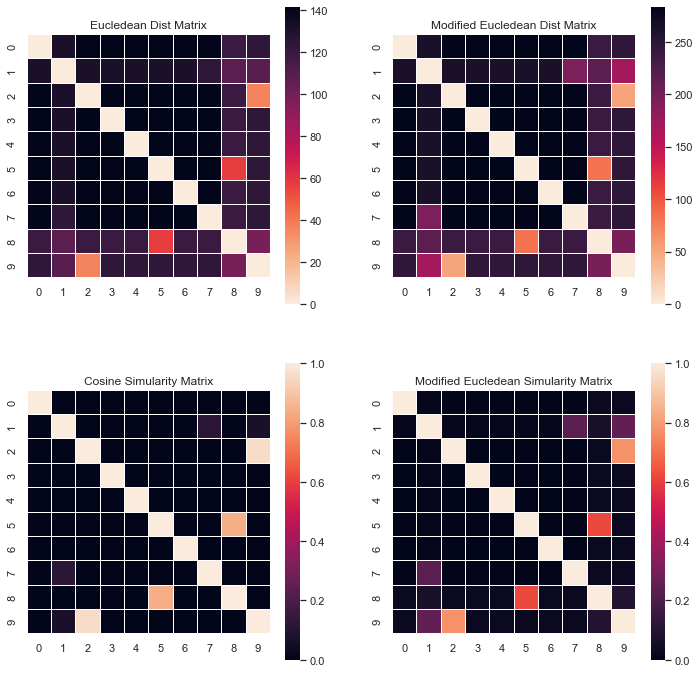

,Baby,Beauty,Clothing,Construction,Furniture_Bedroom,Furniture_Home,Gardening,HomeAppliance,SecuritySignals,Technology,size
SellerGroupId,,,,,,,,,,,
0,0,0,0,0,0,0,0,100,0,0,178
1,0,0,0,10,0,0,85,0,0,0,3
2,0,0,0,0,0,100,0,0,0,0,140
3,0,0,0,0,100,0,0,0,0,0,82
4,0,100,0,0,0,0,0,0,0,0,289
5,0,0,100,0,0,0,0,0,0,0,45
6,0,0,0,0,0,0,0,0,0,100,145
7,0,0,0,100,0,0,0,0,0,0,66
8,35,0,55,0,0,0,0,0,0,0,1


In [14]:
#print heatmap of similarity scores
sns.set(rc = {'figure.figsize':(10,5)})

numberOfCols = 10
SellerGroupsSubset = SellerUniqueGroups.set_index('SellerGroupId').filter(items = range(0,numberOfCols), axis=0)
SellerGroupsSubset = SellerGroupsSubset.loc[:, SellerGroupsSubset.any()]

SellerCosSubset = SellerGroupCosineSimularity[SellerGroupCosineSimularity['SellerGroupId'].isin(range(numberOfCols))].iloc[0:numberOfCols,1:numberOfCols+1]

SellerGroupEuclideanSubset = SellerGroupEuclideanDist[SellerGroupEuclideanDist['SellerGroupId'].isin(range(numberOfCols))].iloc[0:numberOfCols,1:numberOfCols+1]
SellerModEucSimSubset = SellerModEucSim[SellerModEucSim['SellerGroupId'].isin(range(numberOfCols))].iloc[0:numberOfCols,1:numberOfCols+1]
SellerModEucDistSubset = SellerModEucDist[SellerModEucDist['SellerGroupId'].isin(range(numberOfCols))].iloc[0:numberOfCols,1:numberOfCols+1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

cmap = sns.cm.rocket_r
ax1.set_title('Eucledean Dist Matrix')
sns.heatmap(SellerGroupEuclideanSubset, ax=ax1, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

ax2.set_title('Modified Eucledean Dist Matrix')
sns.heatmap(SellerModEucDistSubset, ax=ax2, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

cmap = sns.cm.rocket
ax4.set_title('Modified Eucledean Simularity Matrix')
sns.heatmap(SellerModEucSimSubset, ax=ax4, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

ax3.set_title('Cosine Simularity Matrix')
sns.heatmap(SellerCosSubset, ax=ax3, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

plt.show()

SellerGroupsSubset.head(numberOfCols)

### Plot Average Silhouette Scores for various cluster sizes and metrics

Linkage: complete, finished.
Linkage: average, finished.


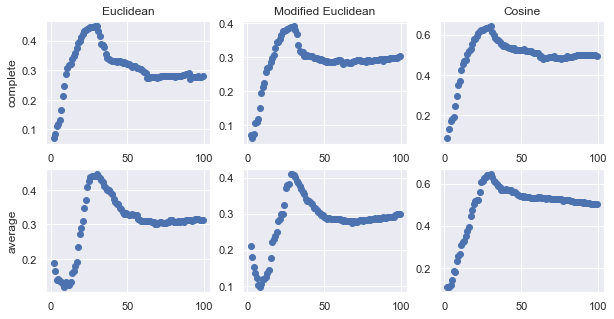

,Distance Measurement,Linkage,Max_Silhouette_Score,Number_Of_Clusters
0,Euclidean,complete,0.448936,30
1,Modified Euclidean,complete,0.392026,30
2,Cosine,complete,0.642732,30
3,Euclidean,average,0.445347,30
4,Modified Euclidean,average,0.408833,29
5,Cosine,average,0.643737,30


In [15]:
Seller_Category_DF = SellerUniqueGroups.sort_values(by='SellerGroupId').drop(columns='size').set_index('SellerGroupId')

SellerModEucDistMat = SellerModEucDist.loc[:, SellerModEucDist.columns!='SellerGroupId']
SellerModEucDistMat = SellerModEucDistMat.to_numpy()

PrintClusterScores_Euc_ModEuc_Cos(Seller_Category_DF, SellerModEucDistMat)

<div class="span5 alert alert-info">
<h3>Buyer Simularity Based on Category Percaentage of Sales</h3>
</div>

#### Group Order Count into table with Customers as Columns and Product Categories as Row

In [16]:
CategoryBuyerMatrix = pd.pivot_table(OL_Data_Simp, 
                                     columns=['customer_unique_id'], 
                                     index=['product_category_name_english'],
                                     values='order_id', 
                                     fill_value=0, 
                                     aggfunc=len).reset_index()

#### Normalize Columns to percentages, rounding down to nearest 5%

In [17]:
CategoryBuyerMatrixNormalized = NormalizeSalesToPercentages(CategoryBuyerMatrix, 
                                                            'product_category_name_english',
                                                            ['customer_unique_id'],
                                                            5)

#### Gerate distance and simularity matrices

In [18]:
(CustomerUniqueGroups,
 CustomerGroupEuclideanDist,
 CustomerGroupCosineSimularity, 
 CustomerModEucDist, 
 CustomerModEucSim)= GenerateAndWriteOutSimularityScoreMatrices(CategoryBuyerMatrixNormalized,
                                                                "product_category_name_english", 
                                                                Categories, 
                                                                'BuyerCategory',
                                                                'CustomerGroupId')

Initial Shape
(31, 93161)
Shape After Droping Duplicates
(31, 536)
Writing ./BuyerCategoryEuclideanDist.csv...
Writing ./BuyerCategoryModifiedEuclideanDist.csv...
Writing ./BuyerCategoryModifiedEuclideanSimularity.csv...
Writing ./BuyerCategoryUniqueGroups.csv...
Writing ./BuyerCategoryCosineSimularity.csv...


In [19]:
CustCat = CategoryBuyerMatrixNormalized.set_index('product_category_name_english').T.reset_index()
CustGroupSorted = CustomerUniqueGroups.sort_values(by='CustomerGroupId')
CustMerged = pd.merge(CustCat,CustGroupSorted, on=Categories )
CustMerged = CustMerged[['customer_unique_id','CustomerGroupId']]

OL_Data_Cat_Simplified = pd.merge(OL_Data_Cat_Simplified, CustMerged, how='left', on='customer_unique_id')
OL_Data_Cat_Simplified.to_csv("./OL_Data_Cat_Simplified.csv", index=False)

#### Plot Groups for Verification

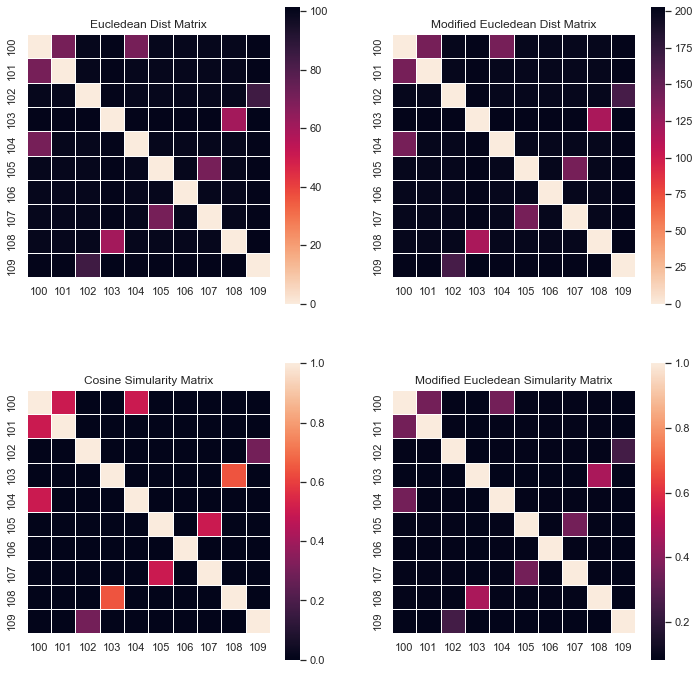

,CustomerGroupId,Art,Auto,Beauty,Clothing,Construction,CoolStuff,Furniture_Bedroom,Furniture_Home,Furniture_LivingRoom,Gardening,Pets,Sports,Technology,Toys,Video Games,size
4,105,50,0,0,0,0,0,0,0,0,50,0,0,0,0,0,3
37,108,0,50,0,0,0,0,0,0,0,0,0,0,0,0,50,2
144,101,0,0,50,0,0,0,0,0,0,0,0,0,0,50,0,10
211,104,0,0,0,50,0,0,0,0,0,0,0,0,50,0,0,12
244,106,0,0,0,0,50,0,0,0,0,0,50,0,0,0,0,4
286,103,0,0,0,0,0,30,0,0,0,0,0,0,0,0,65,1
316,109,0,0,0,0,0,0,65,30,0,0,0,0,0,0,0,19
380,102,0,0,0,0,0,0,0,50,50,0,0,0,0,0,0,8
425,107,0,0,0,0,0,0,0,0,0,50,0,50,0,0,0,12
523,100,0,0,0,0,0,0,0,0,0,0,0,0,50,50,0,11


In [20]:
#print heatmap of similarity scores
cmap = sns.cm.rocket_r
sns.set(rc = {'figure.figsize':(10,5)})

startCol = 100
numberOfCols = 10
endCol = startCol+numberOfCols
CustomerGroupsSubset = CustomerUniqueGroups[CustomerUniqueGroups['CustomerGroupId'].isin(range(startCol,endCol))]
CustomerGroupsSubset = CustomerGroupsSubset.loc[:, CustomerGroupsSubset.any()]

CustomerCosSubset = CustomerGroupCosineSimularity[CustomerGroupCosineSimularity['CustomerGroupId'].isin(range(startCol,endCol))].iloc[:,startCol+1:endCol+1]

CustomerGroupEuclideanSubset = CustomerGroupEuclideanDist[CustomerGroupEuclideanDist['CustomerGroupId'].isin(range(startCol,endCol))].iloc[:,startCol+1:endCol+1]
CustomerModEucSimSubset = CustomerModEucSim[CustomerModEucSim['CustomerGroupId'].isin(range(startCol,endCol))].iloc[:,startCol+1:endCol+1]
CustomerModEucDistSubset = CustomerModEucDist[CustomerModEucDist['CustomerGroupId'].isin(range(startCol,endCol))].iloc[:,startCol+1:endCol+1]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

cmap = sns.cm.rocket_r
ax1.set_title('Eucledean Dist Matrix')
sns.heatmap(CustomerGroupEuclideanSubset, ax=ax1, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

ax2.set_title('Modified Eucledean Dist Matrix')
sns.heatmap(CustomerModEucDistSubset, ax=ax2, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

cmap = sns.cm.rocket
ax4.set_title('Modified Eucledean Simularity Matrix')
sns.heatmap(CustomerModEucSimSubset, ax=ax4, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

ax3.set_title('Cosine Simularity Matrix')
sns.heatmap(CustomerCosSubset, ax=ax3, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

plt.show()

CustomerGroupsSubset


### Plot Average Silhouette Scores for various cluster sizes and metrics

Linkage: complete, finished.
Linkage: average, finished.


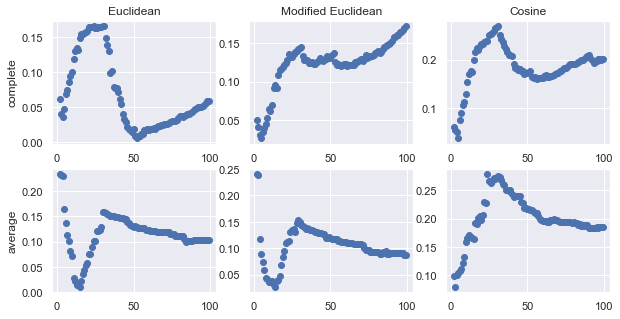

,Distance Measurement,Linkage,Max_Silhouette_Score,Number_Of_Clusters
0,Euclidean,complete,0.166001,24
1,Modified Euclidean,complete,0.172348,99
2,Cosine,complete,0.269330,31
3,Euclidean,average,0.233287,2
4,Modified Euclidean,average,0.239850,2
5,Cosine,average,0.278595,24


In [21]:
Customer_Category_DF = CustomerUniqueGroups.sort_values(by='CustomerGroupId').drop(columns=['size']).set_index('CustomerGroupId')

CustomerModEucDistMat = CustomerModEucDist.loc[:, CustomerModEucDist.columns!='CustomerGroupId']
CustomerModEucDistMat = CustomerModEucDistMat.to_numpy()

PrintClusterScores_Euc_ModEuc_Cos(Customer_Category_DF, CustomerModEucDistMat)

<div class="span5 alert alert-info">
<h3>Buyer Simularity Based on Products</h3>
</div>

#### Create Sparse Matrix of Customers by Products

In [22]:
#Get Orders, customers and Products
#Order number, and customer unique ID will be repeated for each product in an order
cusProd = OL_Data[['order_id','customer_unique_id','product_id']]

#Separate out Orders and Customers
cusOrders = OL_Data[['order_id','customer_unique_id']]
#Drop all repeats
cusOrders = cusOrders.drop_duplicates()
print("All orders shape: {0}".format(cusOrders.shape))
#Drop customers that only have one order, hard to compare them, and matrix becomes unmanageable
cusOrders = cusOrders[cusOrders.customer_unique_id.duplicated(keep=False)]
print("Orders from customers with multiple orders shape: {0}".format(cusOrders.shape))

#Drop duplicate combos of order, customer, and product
cusProd = cusProd.drop_duplicates()
#Drop customers that do not have multiple orders
cusProd = cusProd[cusProd['customer_unique_id'].isin(cusOrders['customer_unique_id'])]
#Keep only customer and product
cusProd = cusProd[['customer_unique_id','product_id']]
print("Customer-product connections from customers with multiple Orders - shape: {0}".format(cusProd.shape))

#Drop duplicate pairings and sort values
cusProd = cusProd.drop_duplicates()
cusProd = cusProd.sort_values(by='customer_unique_id')
print("Uniqe Customer-product connections from customers with multiple Orders - shape: {0}".format(cusProd.shape))

#assign each customer an index in sparse array
row = list(cusProd.customer_unique_id)
customers = list(set(cusProd['customer_unique_id']))
rowDict = dict(zip(customers, range(len(customers))))

#assign each product an index in sparse array
col = list(cusProd.product_id)
products = list(set(cusProd['product_id']))
colDict = dict(zip(products, range(len(products))))

print("Unique Customers - {0}".format(len(customers)))
print("Unique Products - {0}".format(len(products)))

print("replacing customer indices...")
cusProd.replace({'customer_unique_id': rowDict}, inplace=True)
print("replacing product indices...")
cusProd.replace({'product_id':colDict}, inplace=True)


All orders shape: (97659, 2)
Orders from customers with multiple orders shape: (6059, 2)
Customer-product connections from customers with multiple Orders - shape: (6494, 2)
Uniqe Customer-product connections from customers with multiple Orders - shape: (6062, 2)
Unique Customers - 2867
Unique Products - 4520
replacing customer indices...
replacing product indices...


#### Set Data in sparse array as percentage of that customers purchases

In [23]:
#Set Data in sparse array as percentage of that customers purchases, 
#so each column (customer) will add to 100%, and each row represents a product

#This is consistent with the Normalized Matrices in other sections, and will
#not require calling NormalizeSalesToPercentages funciton for this DataFrame, which 
#will take some given the ammount of Data
data = np.array([])
cusProdCounts = cusProd.groupby(by='customer_unique_id').size()

for i in range(len(cusProdCounts)):
    data = np.append(data, np.floor(np.ones(cusProdCounts[i])/cusProdCounts[i]*100))

#### Generate the Sparse DataFrame, dropping any duplicate rows.

In [24]:
from scipy.sparse import csr_matrix

#Generate the Sparse DataFrame, dropping any duplicate rows.
#This creates Product Groups, not individual products, while
# GenerateAndWriteOutSimularityScoreMatrices below will create customer groups in a similar fashion.
sparse_matrix = csr_matrix((data, (cusProd['product_id'], cusProd['customer_unique_id'])), shape=(len(products), len(customers)))
sparseDF = pd.DataFrame(sparse_matrix.toarray(), columns=customers)
sparseDF.insert(0, 'product_id', products)

print("Sparse DataFrame shape with duplicate product rows - {0}".format(sparseDF.shape))
sparseDF2 = sparseDF.set_index('product_id').drop_duplicates().reset_index()
print("Sparse DataFrame shape with duplicates removed - {0}".format(sparseDF2.shape))

Sparse DataFrame shape with duplicate product rows - (4520, 2868)
Sparse DataFrame shape with duplicates removed - (3349, 2868)


#### Gerate distance and simularity matrices

In [25]:
(CustomerUniqueProductGroups,
 CustomerProductGroupEuclideanDist,
 CustomerProductGroupCosineSimularity, 
 CustomerProductModEucDist, 
 CustomerProductModEucSim)= GenerateAndWriteOutSimularityScoreMatrices(sparseDF2,
                                                                "product_id", 
                                                                list(sparseDF2['product_id']), 
                                                                'Product_Customer_',
                                                                'CustomerProductGroupId',
                                                                True)

Initial Shape
(3349, 2867)
Shape After Droping Duplicates
(3349, 2810)
Writing ./Product_Customer_EuclideanDist.csv...
0.0% 
0.9967960128159488% 
1.9935920256318975% 
2.9903880384478465% 
3.987184051263795% 
4.983980064079744% 
5.980776076895693% 
6.977572089711641% 
7.97436810252759% 
8.971164115343539% 
9.967960128159488% 
10.964756140975435% 
11.961552153791386% 
12.958348166607333% 
13.955144179423282% 
14.95194019223923% 
15.94873620505518% 
16.94553221787113% 
17.942328230687078% 
18.939124243503024% 
19.935920256318976% 
20.932716269134925% 
21.92951228195087% 
22.92630829476682% 
23.923104307582772% 
24.919900320398717% 
25.916696333214666% 
26.913492346030615% 
27.910288358846564% 
28.90708437166251% 
29.90388038447846% 
30.90067639729441% 
31.89747241011036% 
32.89426842292631% 
33.89106443574226% 
34.88786044855821% 
35.884656461374156% 
36.8814524741901% 
37.87824848700605% 
38.875044499821996% 
39.87184051263795% 
40.8686365254539% 
41.86543253826985% 
42.8622285510858% 
4

In [26]:
CustProdCat = sparseDF2.set_index('product_id').T.reset_index()
CustProdGroupSorted = CustomerUniqueProductGroups.sort_values(by='CustomerProductGroupId')
CustProdMerged = pd.merge(CustProdCat,CustProdGroupSorted, on=list(sparseDF2['product_id']))
CustProdMerged = CustProdMerged[['index','CustomerProductGroupId']]
CustProdMerged = CustProdMerged.rename(columns={"index": "customer_unique_id"})


OL_Data_Cat_Simplified = pd.merge(OL_Data_Cat_Simplified, CustProdMerged, how='left', on='customer_unique_id')
OL_Data_Cat_Simplified.to_csv("./OL_Data_Cat_Simplified.csv", index=False)

#### Plot Groups for Verification

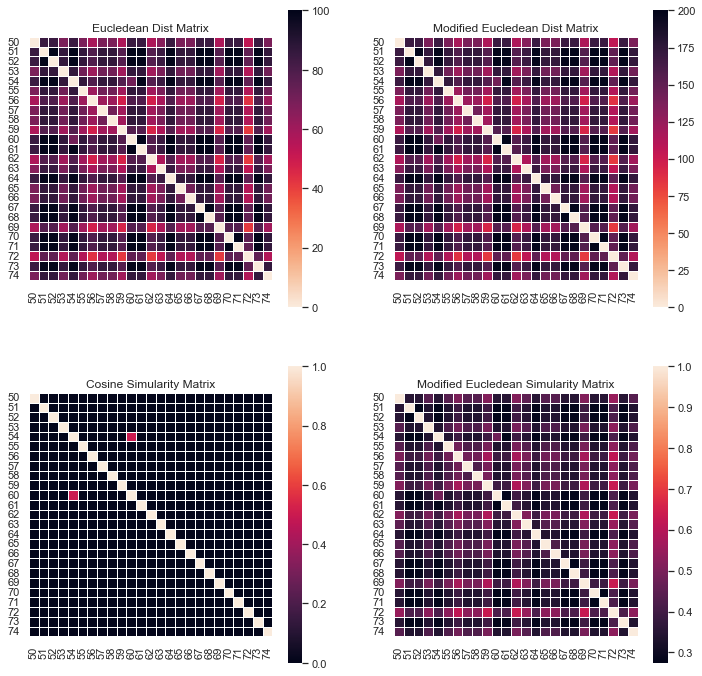

,CustomerProductGroupId,f6d1df8e2ffa44fec7c8afa46ac7ddec,ed01ede241c5149867b22ad7f03cba44,d14fc36666bc80405693671778350124,33f17ed3c6906f7a7ae17a0843536db4,f9259c9e7c0f12c70f7a81409680a5ff,c38d96175ed7d2d5c3391317b77f8eb0,5d92abea542c2022dfee91dd630f2697,bed9b7934576c9ba61b6ba6f3babc698,165f86fe8b799a708a20ee4ba125c289,...,06edb72f1e0c64b14c5b79353f7abea3,a2a61ecd4e916c3ff787c137d23957bb,1b7384e0f9f5e4cb914cd3f5535a4cab,70d01ae15a5d5ee38388b90c0470d9b0,fecf6223a3494f35362f670e571d2a04,13c6408395db73f81805ef46fa6ac926,53759a2ecddad2bb87a079a1f1519f73,154e7e31ebfa092203795c972e5804a6,d0168e734683113fd73658071715084a,size
2153,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2279,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1994,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,1
1176,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2659,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
27,55,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1637,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1
1052,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2800,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1
181,59,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [37]:
#print heatmap of similarity scores
cmap = sns.cm.rocket_r
sns.set(rc = {'figure.figsize':(10,5)})

startCol =50
numberOfCols =25
endCol = startCol+numberOfCols
GroupName = 'CustomerProductGroupId'


CustomerProdGroupsSubset = CustomerUniqueProductGroups.sort_values(by=GroupName)[CustomerUniqueProductGroups[GroupName].isin(range(startCol,endCol))]
CustomerProdGroupsSubset = CustomerProdGroupsSubset.loc[:, CustomerProdGroupsSubset.any()]


CustomerProdCosSubset = CustomerProductGroupCosineSimularity.sort_values(by=GroupName)[CustomerProductGroupCosineSimularity[GroupName].isin(range(startCol,endCol))].iloc[:,startCol+1:endCol+1]
CustomerProdGroupEuclideanSubset = CustomerProductGroupEuclideanDist.sort_values(by=GroupName)[CustomerProductGroupEuclideanDist[GroupName].isin(range(startCol,endCol))].iloc[:,startCol+1:endCol+1]
CustomerProdModEucSimSubset = CustomerProductModEucSim.sort_values(by=GroupName)[CustomerProductModEucSim[GroupName].isin(range(startCol,endCol))].iloc[:,startCol+1:endCol+1]
CustomerProdModEucDistSubset = CustomerProductModEucDist.sort_values(by=GroupName)[CustomerProductModEucDist[GroupName].isin(range(startCol,endCol))].iloc[:,startCol+1:endCol+1]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

cmap = sns.cm.rocket_r
ax1.set_title('Eucledean Dist Matrix')
sns.heatmap(CustomerProdGroupEuclideanSubset, ax=ax1, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

ax2.set_title('Modified Eucledean Dist Matrix')
sns.heatmap(CustomerProdModEucDistSubset, ax=ax2, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

cmap = sns.cm.rocket
ax4.set_title('Modified Eucledean Simularity Matrix')
sns.heatmap(CustomerProdModEucSimSubset, ax=ax4, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

ax3.set_title('Cosine Simularity Matrix')
sns.heatmap(CustomerProdCosSubset, ax=ax3, xticklabels=True, yticklabels=True, cmap=cmap, linewidth=1, linecolor='w', square=True)

plt.show()

CustomerProdGroupsSubset


### Plot Average Silhouette Scores for various cluster sizes and metrics

Linkage: complete, finished.
Linkage: average, finished.


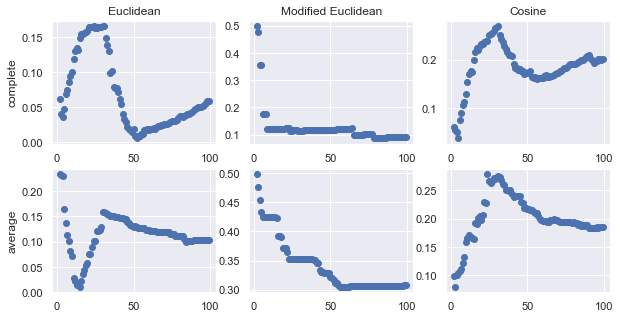

,Distance Measurement,Linkage,Max_Silhouette_Score,Number_Of_Clusters
0,Euclidean,complete,0.166001,24
1,Modified Euclidean,complete,0.497897,2
2,Cosine,complete,0.269330,31
3,Euclidean,average,0.233287,2
4,Modified Euclidean,average,0.497897,2
5,Cosine,average,0.278595,24


In [28]:
Customer_Product_DF = CustomerUniqueProductGroups.sort_values(by='CustomerProductGroupId').drop(columns=['size']).set_index('CustomerProductGroupId')

CustomerProdModEucDistMat = CustomerProductModEucDist.loc[:, CustomerProductModEucDist.columns!='CustomerProductGroupId']
CustomerProdModEucDistMat = CustomerProdModEucDistMat.to_numpy()



PrintClusterScores_Euc_ModEuc_Cos(Customer_Category_DF, CustomerProdModEucDistMat)